In [ ]:
!pip install transformers torchvision pycocotools -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
DATASET_ROOT = '/content/drive/MyDrive/ROB498-004/Final/dawn_dataset/test'

IMAGES_DIR = os.path.join(DATASET_ROOT, '')
ANNOTATION_PATH = os.path.join(DATASET_ROOT, '_annotations.coco.json')

In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import json
import torchvision.transforms as T
from tqdm import tqdm
import os
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [ ]:
with open(ANNOTATION_PATH, 'r') as f:
    coco_data = json.load(f)

id_to_filename = {img["id"]: img["file_name"] for img in coco_data["images"]}
image_id_to_weather = {img["id"]: img["file_name"].split('-')[0] for img in coco_data["images"]}
weather_types = set(image_id_to_weather.values())

weather_to_image_paths = {weather: [] for weather in weather_types}
for img_id, fname in id_to_filename.items():
    weather = image_id_to_weather[img_id]
    weather_to_image_paths[weather].append(os.path.join(IMAGES_DIR, fname))

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def run_inference_and_eval(images, weather, coco_gt):
    results = []

    for img_path in tqdm(images, desc=f"Weather: {weather}"):
        image = Image.open(img_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        target_sizes = torch.tensor([image.size[::-1]]).to(device)
        results_per_image = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

        image_id = [k for k, v in id_to_filename.items() if v == os.path.basename(img_path)][0]

        for score, label, box in zip(results_per_image["scores"], results_per_image["labels"], results_per_image["boxes"]):
            box = box.tolist()
            results.append({
                "image_id": image_id,
                "category_id": int(label),
                "bbox": [box[0], box[1], box[2]-box[0], box[3]-box[1]],
                "score": score.item()
            })

    result_file = f'detr_results_{weather}.json'
    with open(result_file, 'w') as f:
        json.dump(results, f, indent=2)

    coco_dt = coco_gt.loadRes(result_file)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

In [ ]:
coco_gt = COCO(ANNOTATION_PATH)

for weather, image_paths in weather_to_image_paths.items():
    run_inference_and_eval(image_paths, weather, coco_gt)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


Weather: rain_storm: 100%|██████████| 28/28 [00:29<00:00,  1.05s/it]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Weather: snow_storm: 100%|██████████| 14/14 [00:13<00:00,  1.06it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Weather: mist: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Weather: foggy: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Weather: sand_storm_g2_: 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.053
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Weather: dusttornado: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Weather: haze: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Weather: sand_storm: 100%|██████████| 21/21 [00:20<00:00,  1.04it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

category_id_to_name = {cat["id"]: cat["name"] for cat in coco_gt.dataset["categories"]}

def draw_boxes(ax, boxes, labels, scores=None, color='red', title=''):
    for i, box in enumerate(boxes):
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        label = category_id_to_name.get(labels[i], str(labels[i]))
        score_str = f'{scores[i]:.2f}' if scores is not None else ''
        ax.text(x, y, f'{label} {score_str}', color=color, fontsize=8, verticalalignment='top')

def visualize_prediction_and_gt(img_path, image_id):
    image = Image.open(img_path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

    ann_ids = coco_gt.getAnnIds(imgIds=image_id)
    anns = coco_gt.loadAnns(ann_ids)
    gt_boxes = [ann["bbox"] for ann in anns]
    gt_labels = [ann["category_id"] for ann in anns]

    pred_boxes = results["boxes"].cpu().numpy()
    pred_scores = results["scores"].cpu().numpy()
    pred_labels = results["labels"].cpu().numpy()

    pred_boxes_coco = [[x0, y0, x1-x0, y1-y0] for x0, y0, x1, y1 in pred_boxes]

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    draw_boxes(ax, gt_boxes, gt_labels, color='green', title='Ground Truth')
    draw_boxes(ax, pred_boxes_coco, pred_labels, scores=pred_scores, color='red', title='Prediction')
    plt.title(f"Predictions (Red) vs Ground Truth (Green)")
    plt.axis('off')
    plt.show()


Weather Samples: rain_storm


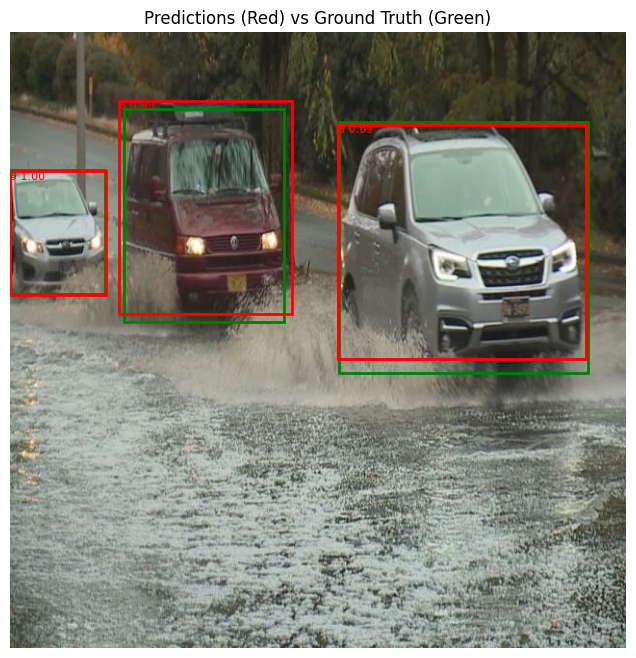


Weather Samples: snow_storm


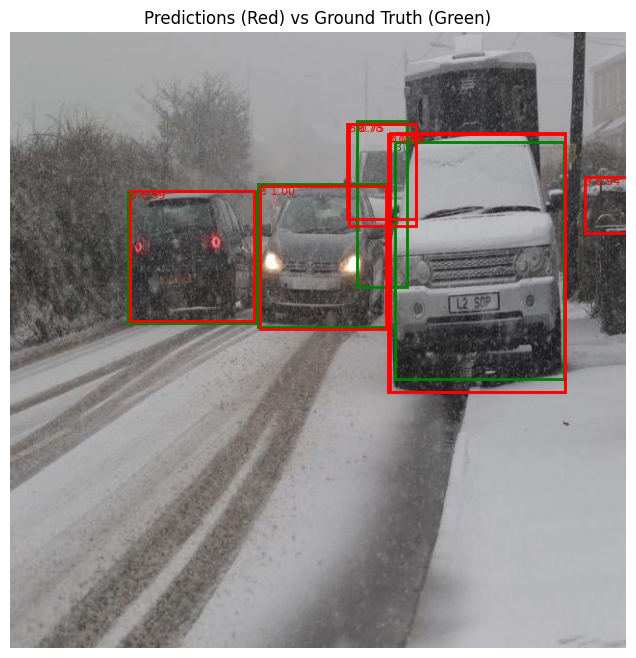


Weather Samples: mist


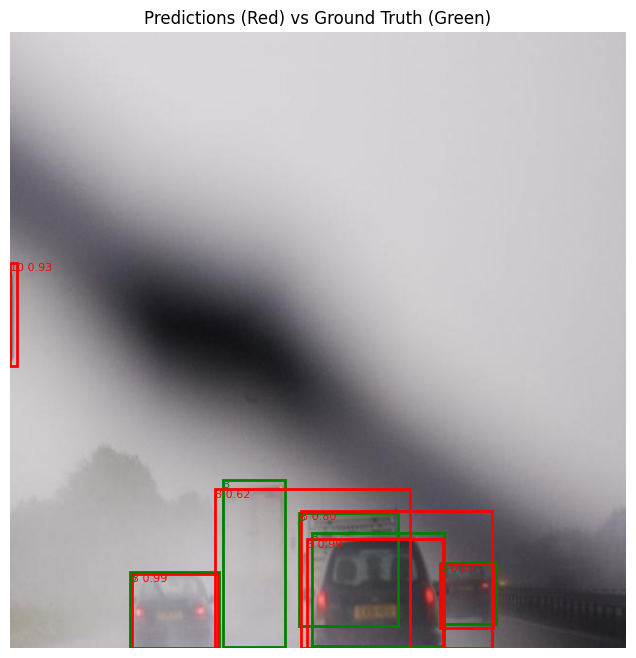


Weather Samples: foggy


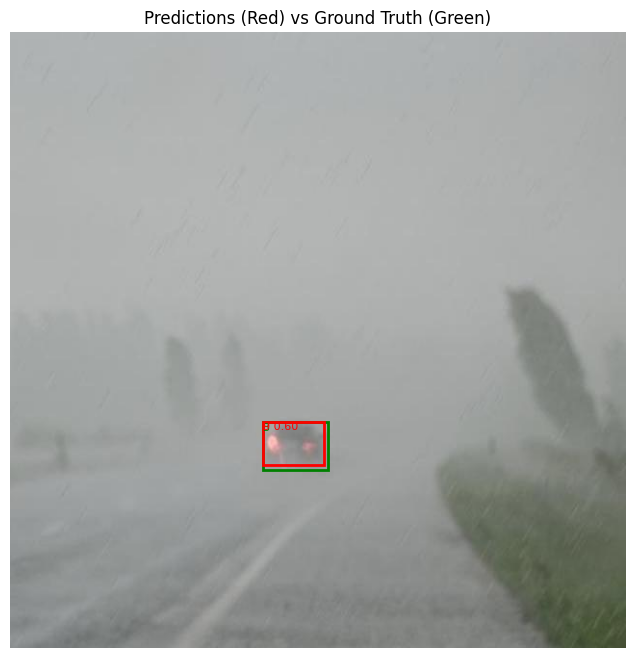


Weather Samples: sand_storm_g2_


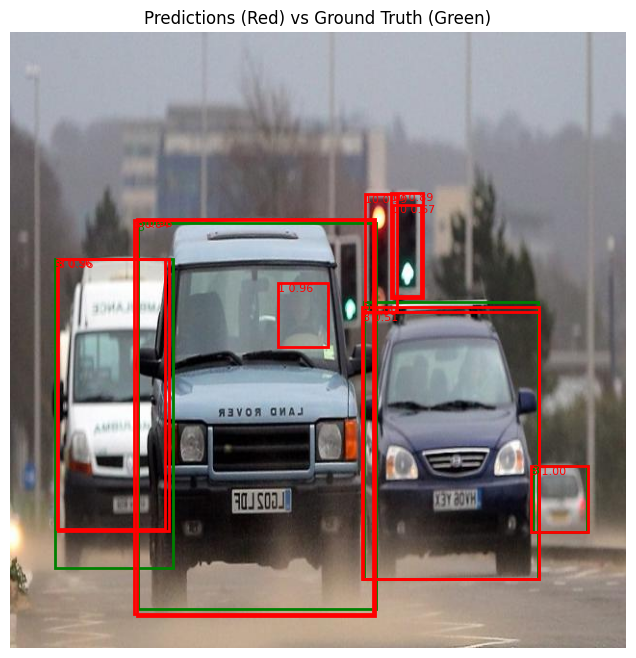


Weather Samples: dusttornado


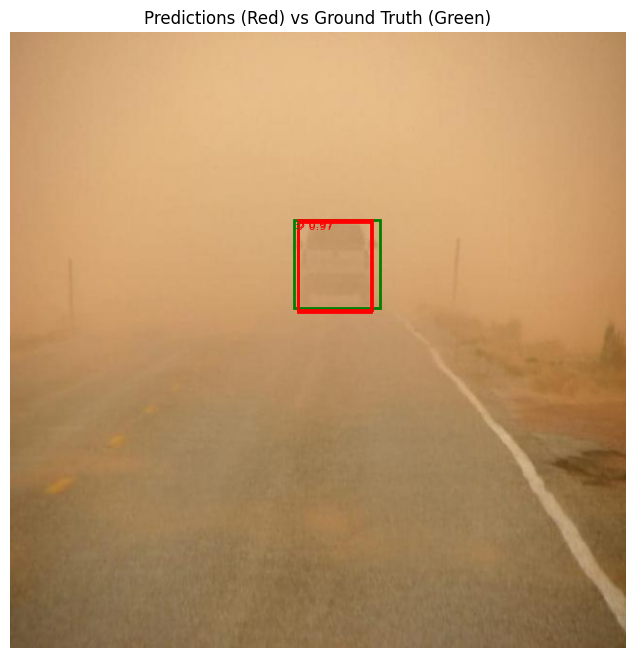


Weather Samples: haze


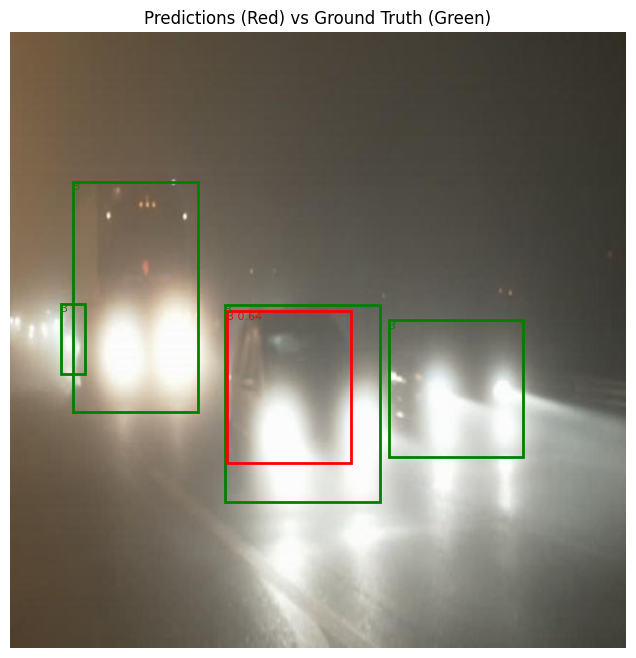


Weather Samples: sand_storm


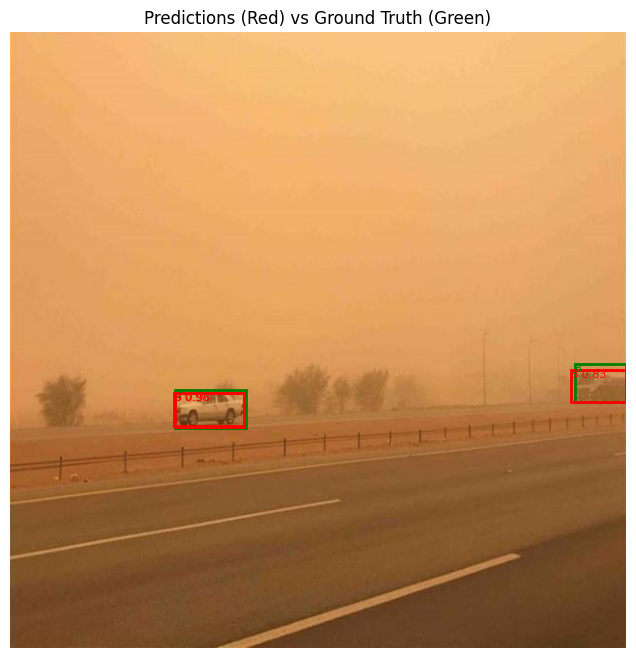

In [ ]:
for weather, image_paths in weather_to_image_paths.items():
    print(f"\nWeather Samples: {weather}")
    sample_img_path = random.choice(image_paths)
    sample_image_id = [k for k, v in id_to_filename.items() if v == os.path.basename(sample_img_path)][0]
    visualize_prediction_and_gt(sample_img_path, sample_image_id)